# Fig. 1 Introducing the spatial pattern 

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

In [118]:
#%matplotlib qt
%matplotlib inline

In [92]:
"""plot style"""
linewidth = 4
mpl.rc('axes', linewidth=linewidth)
mpl.rc('font', family='Arial')
fontsize = 24


colors = {'no_inj': [0.8, 0.8, 0.8],
         'mock': [0.4, 0.4, 0.4],
         'e.coli': [0, 0.4, 0]}

def style_axes(ax, fontsize=24):
    plt.minorticks_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    plt.tight_layout()
    
    return ax


In [11]:
"""high dose data"""
# 18h-18C 24 hpi E. coli
df_inj = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_24.pkl')
# 18h-18C 24 hpi mock
df_mock = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_mock.pkl')
# 18h-18C 24 hpi no injection
df_no = pd.read_pickle(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/df_emL3_noinj.pkl')

"""older 10x diluted data"""
# 3h-22C 24 hpi mock
df_e_mock = pd.read_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_eL3_ctl.pkl')
# 18h-24C 24 hpi no injection
df_m_no = pd.read_pickle(r'/media/brandon/Data1/Brandon/fly_immune/diptericin_paper/manual_analysis/df_mL3_24_noinj.pkl')

df_inj


,experiment_id,y,x,dpt_gfp,mem_mch
0,0,240.70486,1269.328656,5927.750994,9018.343675
1,0,396.410604,1258.712355,4821.583134,8898.338107
2,0,592.812167,1260.481739,6446.630867,8355.653142
3,0,713.130241,634.119998,2272.979316,8869.243437
4,0,859.989067,605.809863,2142.789181,9112.609387
...,...,...,...,...,...
6126,19,4787.100318,1505.411505,1899.669849,8088.492442
6127,19,4660.289762,1561.294123,2062.060461,9410.208433
6128,19,4838.684273,1720.344651,930.402546,6819.805887
6129,19,4666.737756,1165.817135,879.618934,7400.588703


## Scatter plot of median intensities

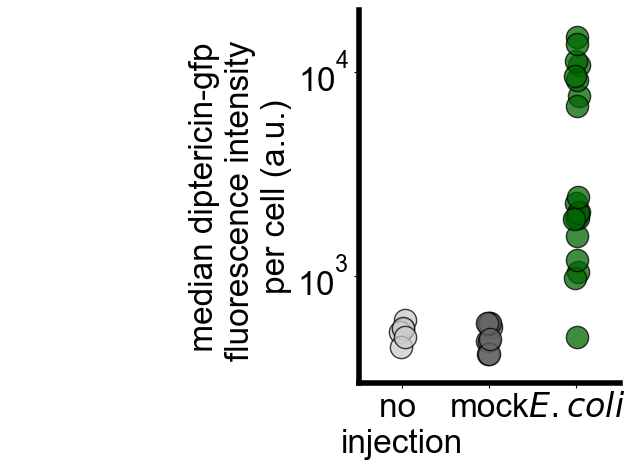

In [119]:
"""scatter plot of median intensities"""
plt.figure()

# no injection --- pool all samples
x = 0
color = colors['no_inj']
all_medians = []
df = df_no
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

df = df_m_no
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

plt.plot(x * np.ones(len(all_medians)) + sigma_x * np.random.normal(size=len(all_medians)), 
         all_medians, 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

# mock injection --- pool all samples
x = 1
color = colors['mock']
all_medians = []
df = df_mock
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

df = df_e_mock
medians = df.groupby(by='experiment_id').median().dpt_gfp.values
all_medians.extend(medians)

plt.plot(x * np.ones(len(all_medians)) + sigma_x * np.random.normal(size=len(all_medians)), 
         all_medians, 'ko', markerfacecolor=color, markersize=16, alpha=0.75)

# injected group
x = 2
color = colors['e.coli']
all_medians = df_inj.groupby(by='experiment_id').median().dpt_gfp.values
sigma_x = 0.02

plt.plot(x * np.ones(len(all_medians)) + sigma_x * np.random.normal(size=len(all_medians)), 
         all_medians, 'ko', markerfacecolor=color, markersize=16, alpha=0.75)


plt.xticks([0, 1, 2], labels=['no \ninjection', 'mock', '$E. coli$'], fontsize=fontsize)
plt.xlim([-0.5, x + 0.5])
plt.yticks([1e3, 1e4])
plt.ylim([3e2, 2e4])
plt.ylabel('\n \n \n \n \n median diptericin-gfp \nfluorescence intensity \nper cell (a.u.)', fontsize=fontsize)
plt.yscale('log')
ax = plt.gca()
ax = style_axes(ax)


In [35]:
"""divide samples based on median intensity"""
partial_thresh = 4000
partial_ids = np.where(all_medians < partial_thresh)[0]
complete_ids = np.where(all_medians >= partial_thresh)[0]

## Full intensity distributions

In [65]:
n_bins = 20 + 1


In [66]:
# assemble mock injection distribution
all_mock_intens = []
df = df_mock
intens = df.dpt_gfp.values
all_mock_intens.extend(intens)

df = df_e_mock
intens = df.dpt_gfp.values
all_mock_intens.extend(intens)

mock_bins = np.logspace(np.min(np.log10(all_mock_intens)), np.max(np.log10(all_mock_intens)), n_bins)
counts, _ = np.histogram(all_mock_intens, mock_bins)

mock_prob_dens = counts / np.sum(counts) / np.diff(mock_bins)
mock_bins = mock_bins[:-1]


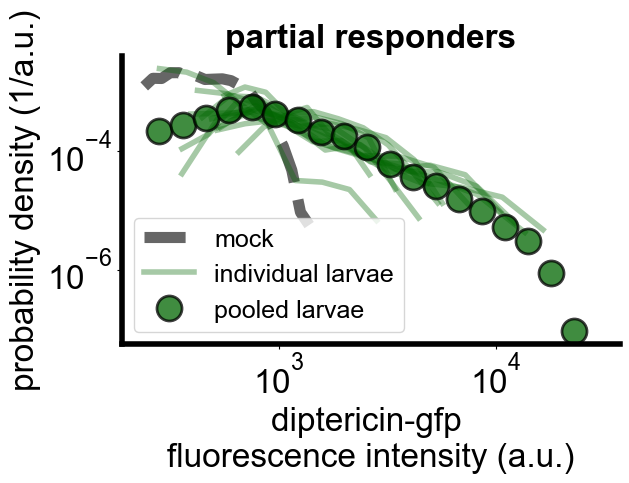

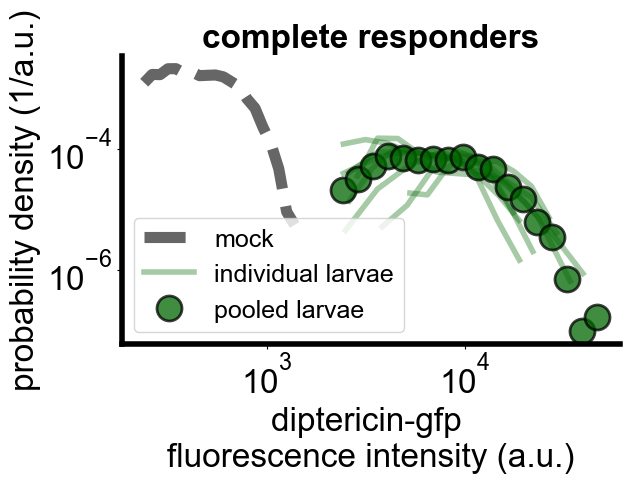

In [120]:
df_partial = df_inj[[eid in partial_ids for eid in df_inj.experiment_id]]
df_complete = df_inj[[eid in complete_ids for eid in df_inj.experiment_id]]

plt.figure()

"""partial"""
# plot mock first
plt.plot(mock_bins, mock_prob_dens, '--', linewidth=2 * linewidth, color=colors['mock'], label='mock')

# plot individual partial dists
df = df_partial
for i, eid in enumerate(df.experiment_id.unique()):
    sub_df = df[df.experiment_id == eid]
    intens = sub_df.dpt_gfp.astype('float32').values
    bins = np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), int(n_bins / 2))
    counts, _ = np.histogram(intens, bins)
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    bins = bins[:-1]
    bins = bins[prob_dens > 1e-7]
    prob_dens = prob_dens[prob_dens > 1e-7]
    if i == 0:
        label = 'individual larvae'
    else:
        label = '_nolabel_'
    plt.plot(bins, prob_dens, '-', color=colors['e.coli'], linewidth=linewidth, alpha=0.35, label=label)

# now plot a pooled distribution
intens = df.dpt_gfp.astype('float32').values
bins = np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), n_bins)
counts, _ = np.histogram(intens, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
bins = bins[:-1]

#plt.plot(bins, prob_dens, '-', color=colors['e.coli'], linewidth=2 * linewidth)
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'], markeredgewidth=2, markersize=18, alpha=0.75, label='pooled larvae')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('diptericin-gfp \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.ylabel('probability density (1/a.u.)', fontsize=fontsize)
plt.title('partial responders', fontsize=fontsize, fontweight='bold')
plt.legend(fontsize=0.75 * fontsize)
ax = plt.gca()
ax = style_axes(ax)

"""complete"""
plt.figure()
# plot mock first
plt.plot(mock_bins, mock_prob_dens, '--', linewidth=2 * linewidth, color=colors['mock'], label='mock')

# plot individual partial dists
df = df_complete
for i, eid in enumerate(df.experiment_id.unique()):
    sub_df = df[df.experiment_id == eid]
    intens = sub_df.dpt_gfp.astype('float32').values
    bins = np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), int(n_bins / 2))
    counts, _ = np.histogram(intens, bins)
    prob_dens = counts / np.sum(counts) / np.diff(bins)
    bins = bins[:-1]
    bins = bins[prob_dens > 1e-7]
    prob_dens = prob_dens[prob_dens > 1e-7]
    if i == 0:
        label = 'individual larvae'
    else:
        label = '_nolabel_'
    plt.plot(bins, prob_dens, '-', color=colors['e.coli'], linewidth=linewidth, alpha=0.35, label=label)

# now plot a pooled distribution
intens = df.dpt_gfp.astype('float32').values
bins = np.logspace(np.min(np.log10(intens)), np.max(np.log10(intens)), n_bins)
counts, _ = np.histogram(intens, bins)
prob_dens = counts / np.sum(counts) / np.diff(bins)
bins = bins[:-1]

#plt.plot(bins, prob_dens, '-', color=colors['e.coli'], linewidth=2 * linewidth)
plt.plot(bins, prob_dens, 'ko', markerfacecolor=colors['e.coli'], markeredgewidth=2, markersize=18, alpha=0.75, label='pooled larvae')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('diptericin-gfp \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.ylabel('probability density (1/a.u.)', fontsize=fontsize)
plt.title('complete responders', fontsize=fontsize, fontweight='bold')
plt.legend(fontsize=0.75 * fontsize)
ax = plt.gca()
ax = style_axes(ax)


## Distribution of expression levels along anterior-posterior axis

In [101]:
with open(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/emL3_24_line_dist.pkl', 'rb') as f:
    line_dist_arr = pickle.load(f).values

# throw out the very first and last ap-bins, as these often have noise in them
line_dist_arr = line_dist_arr[:, 1:-2]

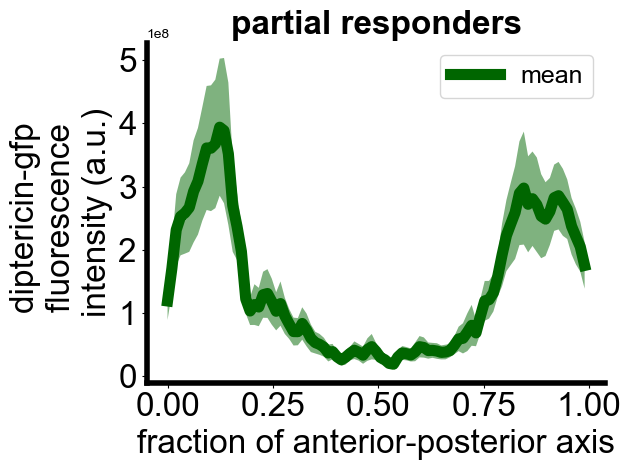

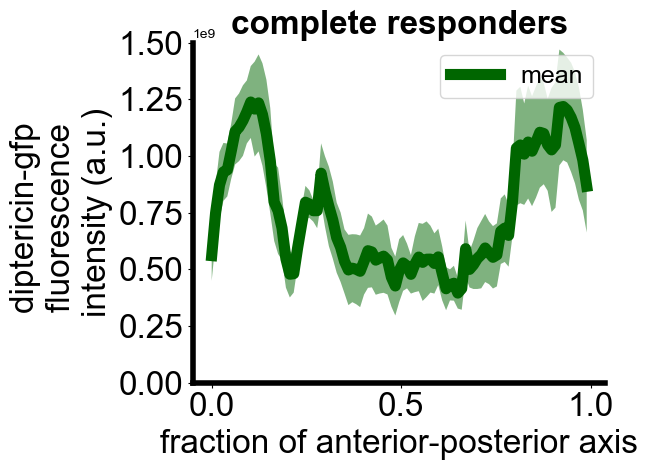

In [121]:
plt.figure()
x = np.arange(line_dist_arr.shape[1]) / line_dist_arr.shape[1]
this_line_dist_arr = line_dist_arr[partial_ids]
"""plot individual dists first"""
# for i in range(len(this_line_dist_arr)):
#     if i == 0:
#         label = 'individual larvae'
#     else:
#         label = '_nolabel_'
#     plt.plot(x, this_line_dist_arr[i], '-', linewidth=linewidth, color=colors['e.coli'], alpha=0.35, label=label)

m = np.mean(this_line_dist_arr, axis=0)
s = np.std(this_line_dist_arr, axis=0) / np.sqrt(len(this_line_dist_arr))
l = m - s
u = m + s
plt.fill_between(x, l, u, facecolor=colors['e.coli'], alpha=0.5)
plt.plot(x, m, '-', linewidth=2*linewidth, color=colors['e.coli'], label='mean')
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel('diptericin-gfp \nfluorescence \nintensity (a.u.)', fontsize=fontsize)
plt.title('partial responders', fontsize=fontsize, fontweight='bold')
plt.legend(fontsize=0.75 * fontsize)
ax = style_axes(plt.gca())

plt.figure()
x = np.arange(line_dist_arr.shape[1]) / line_dist_arr.shape[1]
this_line_dist_arr = line_dist_arr[complete_ids]
"""plot individual dists first"""
# for i in range(len(this_line_dist_arr)):
#     if i == 0:
#         label = 'individual larvae'
#     else:
#         label = '_nolabel_'
#     plt.plot(x, this_line_dist_arr[i], '-', linewidth=linewidth, color=colors['e.coli'], alpha=0.35, label=label)

m = np.mean(this_line_dist_arr, axis=0)
s = np.std(this_line_dist_arr, axis=0) / np.sqrt(len(this_line_dist_arr))
l = m - s
u = m + s
plt.fill_between(x, l, u, facecolor=colors['e.coli'], alpha=0.5)
plt.plot(x, m, '-', linewidth=2*linewidth, color=colors['e.coli'], label='mean')
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel('diptericin-gfp \nfluorescence \nintensity (a.u.)', fontsize=fontsize)
plt.title('complete responders', fontsize=fontsize, fontweight='bold')
plt.ylim([0, 1.5e9])
plt.legend(fontsize=0.75 * fontsize)
ax = style_axes(plt.gca())